# Sandbox notebook for data analysis and visualization

Author: Veikka Immonen

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from PIL import Image

from tqdm import tqdm

import scienceplots

plt.style.use('science')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 12
})

from sklearn.model_selection import train_test_split

plt_original_resolution = plt.rcParams['figure.figsize']
plt_original_resolution

[3.5, 2.625]

## CytoSense

In [2]:
data_dir = Path('./data/FASTVISION-plus')
image_dir = data_dir / 'images'
profile_dir = data_dir / 'profiles'
annotations = pd.read_csv(data_dir / 'annotations.csv')
annotations, len(annotations)

(          ID               class_name
 0          1  Aphanizomenon_flosaquae
 1          2  Aphanizomenon_flosaquae
 2          3  Aphanizomenon_flosaquae
 3          4  Aphanizomenon_flosaquae
 4          5  Aphanizomenon_flosaquae
 ...      ...                      ...
 20045  20046           Tetraselmis_sp
 20046  20047           Tetraselmis_sp
 20047  20048           Tetraselmis_sp
 20048  20049           Tetraselmis_sp
 20049  20050           Tetraselmis_sp
 
 [20050 rows x 2 columns],
 20050)

### Statistics

Number of samples for each instance, how many of them are purely multimodal 
(images + all time series data)?

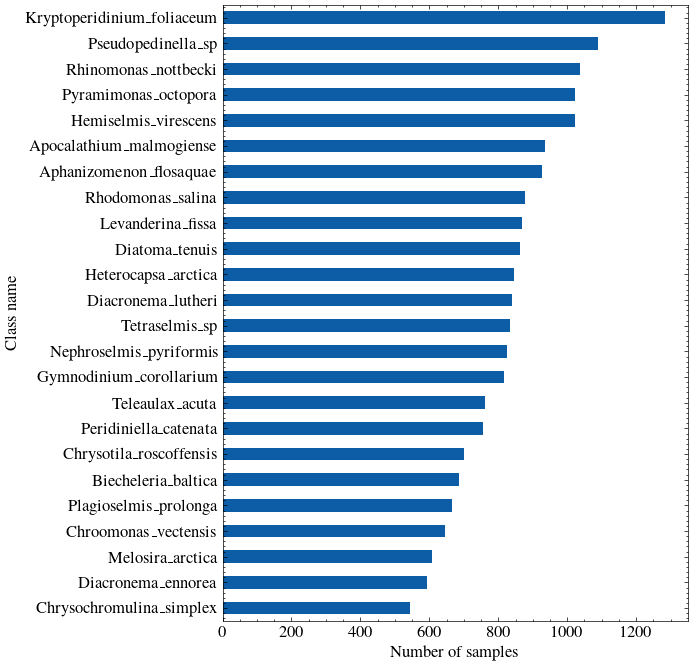

,0
Aphanizomenon_flosaquae,926
Apocalathium_malmogiense,936
Biecheleria_baltica,685
Chroomonas_vectensis,645
Chrysochromulina_simplex,543
Gymnodinium_corollarium,818
Hemiselmis_virescens,1022
Heterocapsa_arctica,846
Levanderina_fissa,870
Melosira_arctica,608


In [3]:
counter = Counter(annotations.class_name)

df = pd.DataFrame(
    data=counter.values(),
    index=counter.keys(),
)

df.sort_values(0).plot(kind='barh', figsize=(6, 8), legend=False)
plt.xlabel('Number of samples')
plt.ylabel('Class name')

plt.savefig(f'figures/sample_counts.pdf')
plt.show()
df

Rough selection would be to exclude classes with less than 10 multimodal samples.

### Visualization

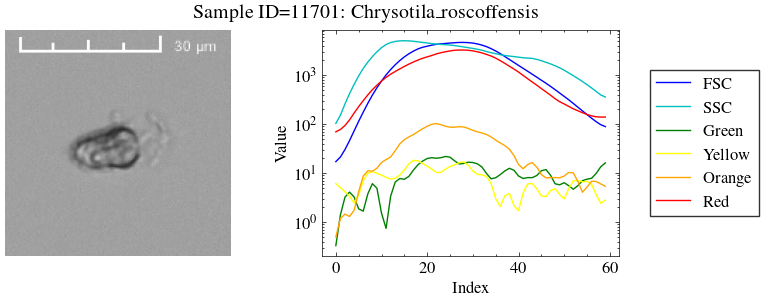

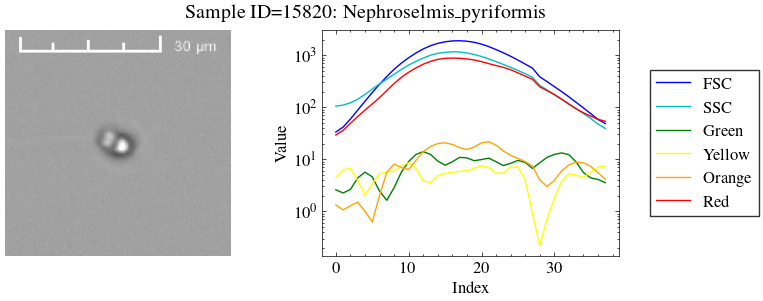

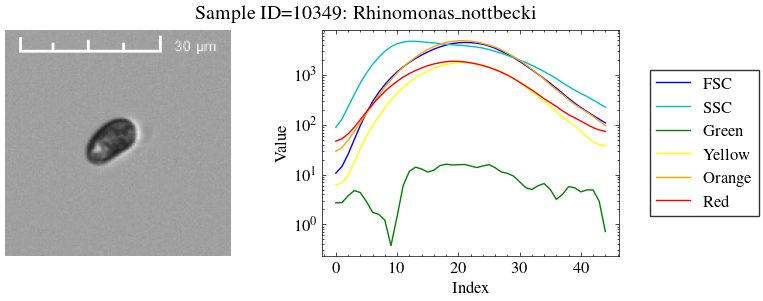

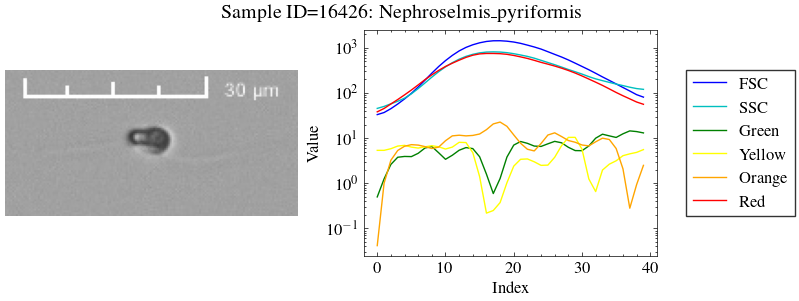

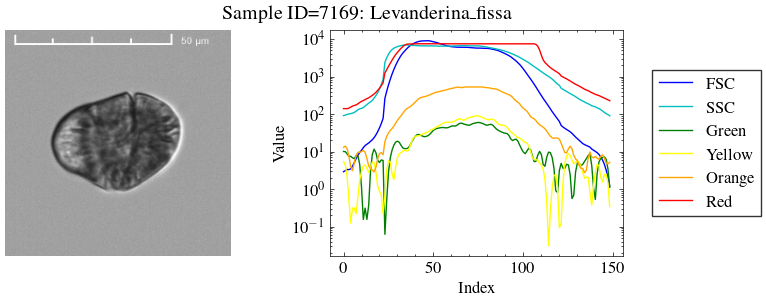

In [7]:
def visualize(sample):
    image = np.array(Image.open(image_dir / f"{sample.ID}.jpg"))
    profile = pd.read_csv(profile_dir / f"{sample.ID}.csv")

    styles = ['b', 'c', 'g', 'yellow', 'orange', 'r', 'k']

    fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained")

    ax1.imshow(image)
    ax1.set_axis_off()

    ax2 = profile.plot(ax=ax2, style=dict(zip(profile.columns, styles)))
    ax2.legend(loc=7, frameon=True, edgecolor='k', fancybox=False, bbox_to_anchor=(1.5, 0.5))
    ax2.set_xlabel('Index')
    ax2.set_ylabel('Value')
    ax2.set_yscale('log')
    # ax2.set_ylim([profile.min().min(), None])

    fig.set_size_inches(8, 3)
    
    plt.suptitle(f'Sample ID={sample.ID}: {sample.class_name}')
    # plt.savefig(f'figures/{sample.X}.pdf')
    plt.show()

for _, sample in annotations[annotations.iloc[:, -2:].T.all()].sample(5).iterrows():
    visualize(sample)



In [9]:
profile = pd.read_csv(profile_dir / f"{sample.X}.csv")
profile.min().min()

NameError: name 'sample' is not defined

In [11]:
multimodal = annotations[(annotations.iloc[:, -2:] == True).all(axis=1)]
class_names, counts = np.unique(multimodal.class_name, return_counts=True)

idx = counts.argsort()[::-1]
class_names = class_names[idx]
counts = counts[idx]
print(counts)

train = pd.DataFrame(columns=multimodal.columns)
test = pd.DataFrame(columns=multimodal.columns)
valid = pd.DataFrame(columns=multimodal.columns)

size=15
for i in range(size):
    annot = multimodal[multimodal.class_name == class_names[i]]
    train_annot, test_annot = train_test_split(annot, train_size=50)
    valid_annot = test_annot.sample(10)
    train = pd.concat([train, train_annot])
    test = pd.concat([test, test_annot])
    valid = pd.concat([valid, valid_annot])

train.to_csv(data_dir / f'train_{size}.csv')
test.to_csv(data_dir / f'test_{size}.csv')
valid.to_csv(data_dir / f'valid_{size}.csv')

[1659 1016  834  792  329  253  219  203  156  146  122  116  101   91
   78   66   53   49   47   43   41   32   28   19   18   17   16   14
   13   11   10    8    3    3    3    1]


In [12]:
table = pd.read_csv('./data/CytoSense/Pulse-shapes_annotated_CS_images.csv')

In [13]:
table = table.iloc[:, -7:].dropna()
max_vals = table.max(0).to_numpy().astype(int)
min_vals = table.min(0).to_numpy().astype(int)

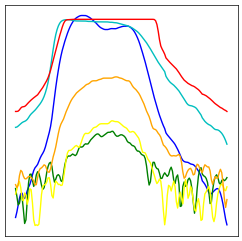

In [32]:
    
for _, sample in annotations[annotations.iloc[:, -2:].T.all()].sample().iterrows():
    x = sample.ID

    image = Image.open(image_dir / f"{x}.jpg")
    profile = pd.read_csv(profile_dir / f"{x}.csv")
    profile = np.log(profile + 1)

    h, w = image.size

    if h == w:
        styles = ['b', 'c', 'g', 'yellow', 'orange', 'r']

        fig, ax = plt.subplots(figsize=(3, 3))
        ax = profile.plot(ax=ax, style=dict(zip(profile.columns, styles)))

        ax.legend().set_visible(False)
    
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        plt.savefig(f'figures/{x}_profile.jpg')
        image = image.resize((256, 256))
        image.save(f'figures/{x}_image.jpg')

        plt.show()
